# Kaggle GI Tract Train

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer


Consider:
https://github.com/catalyst-team/catalyst - training loop - was buggy so abandoned the idea.

https://torchio.readthedocs.io/data/image.html - has simulation of intensity artifacts due to MRI magnetic field inhomogeneity (bias) or k-space motion artifacts.


https://www.kaggle.com/code/yiheng/50-times-faster-way-get-hausdorff-with-monai 



**Notes**
* create simple model for first submission - done
* Add some augmentation transforms (https://github.com/albumentations-team/albumentations)
    * rotation (10 deg)
    * resize
* Extend training epochs

* remove bad data https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/321979



* Go to 2.5 D method

* Go to 3D method




* add Hausdorff metric https://github.com/mavillan/py-hausdorff
https://www.kaggle.com/code/carnozhao/tract-competiton-metrics



In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from pathlib import Path

#import albumentations as A
from torchvision import transforms


#DATASET_FOLDER = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
DATASET_FOLDER = Path("/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation")
TRAIN_FOLDER = DATASET_FOLDER/"train"

MODEL_FOLDER = DATASET_FOLDER/"kaggle models"
os.makedirs(MODEL_FOLDER, exist_ok=True)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
#DEVICE = "cuda:0"

model_name_base = "Unet-2"

# Data

## Process the Metadata

In [2]:
df2d = pd.read_csv(DATASET_FOLDER/"df2d_metadata.csv")
display(df2d.head())

,Unnamed: 0,large_bowel,small_bowel,stomach,id,case_id_str,case_id,day_num_str,day_num,slice_id,...,match,subpath,filename,im_height,im_width,im_pixel_height,im_pixel_width,slice_thickness,segmentations,fold
0,0,NaN,NaN,NaN,case101_day20_slice_0001,case101,101,day20,20,slice_0001,...,case101/case101_day20/scans/slice_0001,case101/case101_day20/scans/slice_0001_266_266...,slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
1,1,NaN,NaN,NaN,case101_day20_slice_0002,case101,101,day20,20,slice_0002,...,case101/case101_day20/scans/slice_0002,case101/case101_day20/scans/slice_0002_266_266...,slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
2,2,NaN,NaN,NaN,case101_day20_slice_0003,case101,101,day20,20,slice_0003,...,case101/case101_day20/scans/slice_0003,case101/case101_day20/scans/slice_0003_266_266...,slice_0003_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
3,3,NaN,NaN,NaN,case101_day20_slice_0004,case101,101,day20,20,slice_0004,...,case101/case101_day20/scans/slice_0004,case101/case101_day20/scans/slice_0004_266_266...,slice_0004_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0
4,4,NaN,NaN,NaN,case101_day20_slice_0005,case101,101,day20,20,slice_0005,...,case101/case101_day20/scans/slice_0005,case101/case101_day20/scans/slice_0005_266_266...,slice_0005_266_266_1.50_1.50.png,266,266,1.5,1.5,3.0,False,4.0


## Create a Pytorch Dataset

In [3]:
from torchvision.transforms import PILToTensor

In [4]:
class Dataset_from_df(torch.utils.data.Dataset):
    def __init__(self, df, path, joint_transform=None, image_transform=None, mask_transform=None):
        self.df = df
        self.path = path
        self.joint_transform = joint_transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.pil_to_tensor = PILToTensor()

        
    def __len__(self):
        return self.df.shape[0]
    
    #Helper Function to decode RLE
    def _rle_decode_float(self,mask_rle, shape, color_val=1):
        '''
        mask_rle: run-length as string formated (start length)
        shape: (height,width) of array to return 
        Returns numpy array, color_val - mask, 0 - background

        '''
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        #img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

        img = torch.zeros(shape[1]*shape[2])
        for lo, hi in zip(starts, ends):
            img[lo : hi] = color_val
        return img.reshape(shape)    
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        
        img_path = self.path/row.subpath
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #print(img.shape)
        
        lb_class_seg = row.large_bowel
        sb_class_seg = row.small_bowel
        st_class_seg = row.stomach
        
        
        mask = torch.zeros((3, img.shape[1], img.shape[2]))

        if type(lb_class_seg) is str:
            mask[0,:,:] = self._rle_decode_float(lb_class_seg,img.shape,color_val=1)

        if type(sb_class_seg) is str:
            mask[1,:,:] = self._rle_decode_float(sb_class_seg, img.shape,color_val=1)

        if type(st_class_seg) is str:
            mask[2,:,:] = self._rle_decode_float(st_class_seg, img.shape,color_val=1)
        
        
        
        if self.joint_transform:            
            image_stack = torch.cat([img, mask], dim=0)
            image_stack = self.joint_transform(image_stack)
            img = image_stack[0:1]
            mask = image_stack[1:4]
        
        if self.image_transform:
            img = self.image_transform(img)
            
        if self.mask_transform:
            mask = self.mask_transform(mask)
    
        
        return {
            "image": img,
            "mask": mask,
        }
        
        
    
    


In [5]:
dataset = Dataset_from_df(df2d[df2d['segmentations']],TRAIN_FOLDER)

In [6]:
dataset[665]['image'].max()

tensor(10672, dtype=torch.int32)

In [7]:
def plot_data(d):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(d['image'].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image Shape= {d['image'].shape}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(rearrange(d['mask'].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Mask Shape = {d['mask'].shape}")
    plt.axis('off')

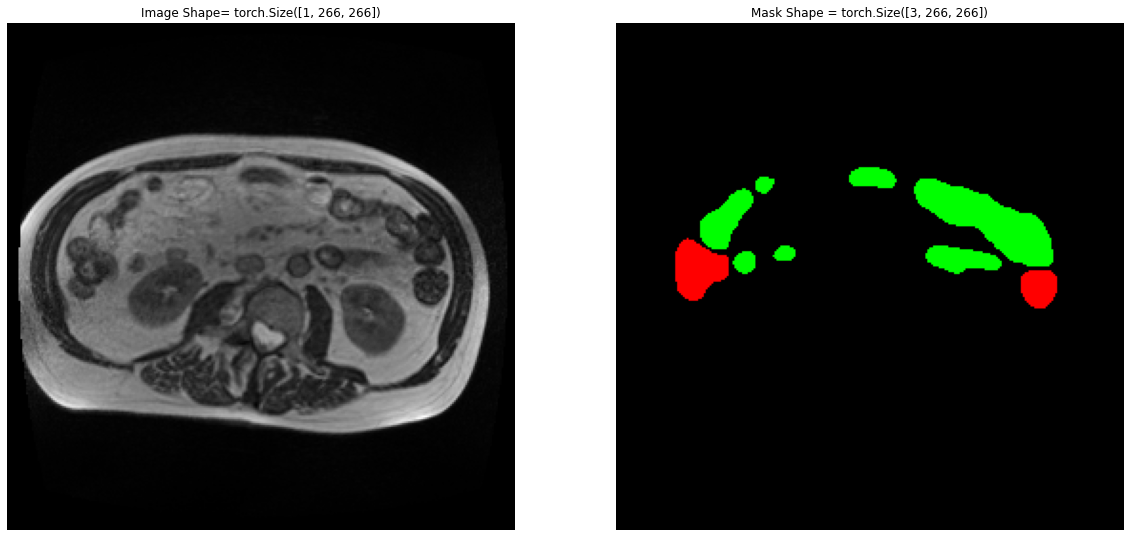

In [8]:
plot_data(dataset[665])

### With n fold cross validation we need a dataset for each fold

In [9]:
def prepare_datasets(df, fold, train_transforms, valid_transforms):
    train_df = df.query("fold!=@fold").query("segmentations==True").reset_index(drop=True)
    valid_df = df.query("fold==@fold").query("segmentations==True").reset_index(drop=True)

    train_dataset = Dataset_from_df(train_df,TRAIN_FOLDER, joint_transform=train_transforms)
    valid_dataset = Dataset_from_df(valid_df,TRAIN_FOLDER, joint_transform=valid_transforms)
    
    return train_dataset, valid_dataset

# Training

In [10]:
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm

## Loss Functions and Metrics

In [11]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

## Training Loops

In [12]:
def trainfp32(epoch, train_dataloader, optimizer, loss_fn, lr_scheduler,
              metric_fn, model):


    model.train()

    training_loss = 0
    metric = 0

    pbar = tqdm(total=len(train_dataloader))

    for batch in train_dataloader:

        optimizer.zero_grad()

        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        #print(images.shape, masks.shape)
        
        output = model(images)

        loss = loss_fn(output, masks)


        loss.backward()

        optimizer.step()

        lr_scheduler.step()

        with torch.no_grad():
            training_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)

        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    training_loss /= len(train_dataloader.dataset)
    metric /= len(train_dataloader.dataset)
    return training_loss, metric

In [13]:
def validatefp32(valid_dataloader, loss_fn, metric_fn, model):
    validation_loss = 0
    metric = 0
    model.eval()
    pbar = tqdm(total=len(valid_dataloader))
    for batch in valid_dataloader:
        images, masks = batch['image'], batch['mask']

        images = images.cuda(non_blocking=True)
        masks = masks.cuda(non_blocking=True)

        output = model(images)
        with torch.no_grad():
            loss = loss_fn(output,masks)
            validation_loss += loss.data.item() * images.size(0)
            y_pred = torch.nn.Sigmoid()(output)
            metric += metric_fn(masks,y_pred) * images.size(0)
        pbar.update(1)
    pbar.close()
    torch.cuda.empty_cache()
    validation_loss /= len(valid_dataloader.dataset)
    metric /= len(valid_dataloader.dataset)
    return validation_loss, metric

## Training

In [14]:
class Squarepad(object):
    """Pad the image in a sample to a given size.

    Args:
        output_size (int): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        #print("s",image.size())
        image_size = image.shape[-2::]
        #print("e",image_size)
        p_left, p_top = [(self.output_size - s) // 2 for s in image_size]
        p_right, p_bottom = [self.output_size - (s+pad) for s, pad in zip(image_size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return transforms.functional.pad(image, padding, 0, 'constant')        
        


In [15]:
squarepad_transform = Squarepad(360)  #max image size is 360x310

In [16]:
train_transforms = transforms.Compose(
    [squarepad_transform,
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((320,320),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomRotation(4, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomPerspective(distortion_scale=.2, p=0.5, interpolation=transforms.InterpolationMode.BILINEAR),
    
    ])

In [17]:
valid_transforms = transforms.Compose(
    [squarepad_transform,
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((320,320),interpolation=transforms.InterpolationMode.BICUBIC),
    ])  # multiple of 32 for UUnet

### Training

In [18]:
init_lr = .001
epochs = 20
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [19]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    model.cuda()


    
    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, valid_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999
    
    
    for epoch in range(1, epochs + 1):

        #lr = lr_scheduler.get_last_lr()
        lr = optimizer.param_groups[0]['lr']
        #print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

Fold: 0, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.5040, Metric: 0.395,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.2177, Metric = 0.688
Fold: 0, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.1308, Metric: 0.776,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1452, Metric = 0.745
Fold: 0, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.1060, Metric: 0.800,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1401, Metric = 0.762
Fold: 0, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0986, Metric: 0.813,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1384, Metric = 0.765
Fold: 0, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0997, Metric: 0.810,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1514, Metric = 0.734
Fold: 0, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0911, Metric: 0.828,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1345, Metric = 0.761
Fold: 0, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0879, Metric: 0.839,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1480, Metric = 0.759
Fold: 0, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0831, Metric: 0.847,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1299, Metric = 0.772
Fold: 0, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0796, Metric: 0.855,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1244, Metric = 0.796
Fold: 0, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0749, Metric: 0.866,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1169, Metric = 0.801
Fold: 0, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0709, Metric: 0.875,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1309, Metric = 0.765
Fold: 0, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0668, Metric: 0.883,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1182, Metric = 0.805
Fold: 0, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0650, Metric: 0.888,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1276, Metric = 0.779
Fold: 0, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0615, Metric: 0.894,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1170, Metric = 0.797
Fold: 0, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0589, Metric: 0.900,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1149, Metric = 0.804
Fold: 0, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0571, Metric: 0.905,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1153, Metric = 0.806
Fold: 0, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0553, Metric: 0.908,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1138, Metric = 0.804
Fold: 0, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0539, Metric: 0.911,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1159, Metric = 0.807
Fold: 0, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0533, Metric: 0.912,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1169, Metric = 0.805
Fold: 0, Epoch: 20, LR: 1.252e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0532, Metric: 0.913,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1175, Metric = 0.806
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-2-1.pth
Fold: 1, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.4945, Metric: 0.323,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.2499, Metric = 0.672
Fold: 1, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1379, Metric: 0.761,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1531, Metric = 0.718
Fold: 1, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1071, Metric: 0.796,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1477, Metric = 0.749
Fold: 1, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.1054, Metric: 0.799,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1503, Metric = 0.702
Fold: 1, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0996, Metric: 0.812,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.2538, Metric = 0.544
Fold: 1, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0941, Metric: 0.824,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1343, Metric = 0.769
Fold: 1, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0877, Metric: 0.840,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1352, Metric = 0.754
Fold: 1, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0828, Metric: 0.848,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1185, Metric = 0.797
Fold: 1, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0798, Metric: 0.853,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1252, Metric = 0.765
Fold: 1, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0756, Metric: 0.863,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1234, Metric = 0.796
Fold: 1, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0714, Metric: 0.874,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1222, Metric = 0.788
Fold: 1, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0685, Metric: 0.879,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1119, Metric = 0.806
Fold: 1, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0672, Metric: 0.880,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1127, Metric = 0.805
Fold: 1, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0627, Metric: 0.892,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1159, Metric = 0.803
Fold: 1, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0601, Metric: 0.898,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1118, Metric = 0.805
Fold: 1, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0575, Metric: 0.903,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1144, Metric = 0.805
Fold: 1, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0560, Metric: 0.907,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1104, Metric = 0.815
Fold: 1, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0548, Metric: 0.909,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1116, Metric = 0.813
Fold: 1, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0534, Metric: 0.910,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1109, Metric = 0.813
Fold: 1, Epoch: 20, LR: 1.252e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0532, Metric: 0.912,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1117, Metric = 0.814
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-2-1.pth
Fold: 2, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.5108, Metric: 0.349,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.2381, Metric = 0.609
Fold: 2, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.1255, Metric: 0.782,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1600, Metric = 0.720
Fold: 2, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.1062, Metric: 0.800,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1730, Metric = 0.679
Fold: 2, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0965, Metric: 0.820,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1653, Metric = 0.677
Fold: 2, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0944, Metric: 0.827,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1560, Metric = 0.728
Fold: 2, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0908, Metric: 0.833,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1591, Metric = 0.710
Fold: 2, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0841, Metric: 0.847,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1476, Metric = 0.717
Fold: 2, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0840, Metric: 0.848,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1572, Metric = 0.723
Fold: 2, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0778, Metric: 0.860,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1642, Metric = 0.714
Fold: 2, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0739, Metric: 0.869,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1476, Metric = 0.715
Fold: 2, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0697, Metric: 0.876,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1480, Metric = 0.748
Fold: 2, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0673, Metric: 0.882,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1393, Metric = 0.756
Fold: 2, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0637, Metric: 0.891,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1416, Metric = 0.757
Fold: 2, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0611, Metric: 0.898,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1448, Metric = 0.743
Fold: 2, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0585, Metric: 0.902,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1431, Metric = 0.749
Fold: 2, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0567, Metric: 0.906,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1408, Metric = 0.761
Fold: 2, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0543, Metric: 0.911,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1361, Metric = 0.766
Fold: 2, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0530, Metric: 0.913,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1368, Metric = 0.761
Fold: 2, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0521, Metric: 0.915,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1358, Metric = 0.760
Fold: 2, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0519, Metric: 0.916,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1371, Metric = 0.760
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-2-1.pth
Fold: 3, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.4852, Metric: 0.360,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.1859, Metric = 0.726
Fold: 3, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1338, Metric: 0.764,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.1089, Metric = 0.788
Fold: 3, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1090, Metric: 0.794,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.1201, Metric = 0.746
Fold: 3, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.1038, Metric: 0.803,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.1057, Metric = 0.805
Fold: 3, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0987, Metric: 0.816,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.1090, Metric = 0.783
Fold: 3, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0953, Metric: 0.823,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0931, Metric = 0.827
Fold: 3, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0887, Metric: 0.837,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0958, Metric = 0.822
Fold: 3, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0879, Metric: 0.840,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.1191, Metric = 0.778
Fold: 3, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0800, Metric: 0.857,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0873, Metric = 0.842
Fold: 3, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0777, Metric: 0.861,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0881, Metric = 0.825
Fold: 3, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0742, Metric: 0.868,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0915, Metric = 0.831
Fold: 3, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0694, Metric: 0.878,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0841, Metric = 0.838
Fold: 3, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0668, Metric: 0.885,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0892, Metric = 0.842
Fold: 3, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0635, Metric: 0.891,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0822, Metric = 0.842
Fold: 3, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0609, Metric: 0.897,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0839, Metric = 0.849
Fold: 3, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0587, Metric: 0.902,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0838, Metric = 0.847
Fold: 3, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0568, Metric: 0.905,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0836, Metric = 0.845
Fold: 3, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0555, Metric: 0.909,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0808, Metric = 0.847
Fold: 3, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0546, Metric: 0.910,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0832, Metric = 0.846
Fold: 3, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0541, Metric: 0.911,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0819, Metric = 0.846
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-2-1.pth
Fold: 4, Epoch: 1, LR: 4.000e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.4625, Metric: 0.364,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.2177, Metric = 0.669
Fold: 4, Epoch: 2, LR: 1.043e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1322, Metric: 0.766,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1656, Metric = 0.701
Fold: 4, Epoch: 3, LR: 2.800e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1052, Metric: 0.798,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1371, Metric = 0.750
Fold: 4, Epoch: 4, LR: 5.201e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.1023, Metric: 0.805,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1485, Metric = 0.746
Fold: 4, Epoch: 5, LR: 7.601e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0992, Metric: 0.814,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1557, Metric = 0.727
Fold: 4, Epoch: 6, LR: 9.358e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0939, Metric: 0.825,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1371, Metric = 0.745
Fold: 4, Epoch: 7, LR: 1.000e-03--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0872, Metric: 0.841,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1406, Metric = 0.744
Fold: 4, Epoch: 8, LR: 9.874e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0824, Metric: 0.848,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1329, Metric = 0.754
Fold: 4, Epoch: 9, LR: 9.505e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0800, Metric: 0.855,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1217, Metric = 0.790
Fold: 4, Epoch: 10, LR: 8.909e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0745, Metric: 0.867,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1259, Metric = 0.768
Fold: 4, Epoch: 11, LR: 8.117e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0705, Metric: 0.875,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1312, Metric = 0.769
Fold: 4, Epoch: 12, LR: 7.169e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0689, Metric: 0.879,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1231, Metric = 0.787
Fold: 4, Epoch: 13, LR: 6.112e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0641, Metric: 0.890,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1240, Metric = 0.787
Fold: 4, Epoch: 14, LR: 4.999e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0619, Metric: 0.893,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1259, Metric = 0.784
Fold: 4, Epoch: 15, LR: 3.887e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0594, Metric: 0.898,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1215, Metric = 0.791
Fold: 4, Epoch: 16, LR: 2.830e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0564, Metric: 0.905,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1192, Metric = 0.793
Fold: 4, Epoch: 17, LR: 1.882e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0548, Metric: 0.909,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1164, Metric = 0.795
Fold: 4, Epoch: 18, LR: 1.090e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0537, Metric: 0.911,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1181, Metric = 0.793
Fold: 4, Epoch: 19, LR: 4.949e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0529, Metric: 0.913,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1184, Metric = 0.792
Fold: 4, Epoch: 20, LR: 1.253e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0525, Metric: 0.914,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1177, Metric = 0.793
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-2-1.pth


### More training

In [22]:
init_lr = .0001
epochs = 40
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [23]:
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    model.cuda()


    #Load files from past training to improve apon them
    model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-1.pth"))
    model.load_state_dict(torch.load(model_in_str))
    
    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, valid_transforms)
    
    train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr,weight_decay = 1e-6)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=init_lr, steps_per_epoch=len(train_dataloader),
                                                  epochs=epochs)
    
    
    best_validation_loss = 999

    for epoch in range(1, epochs + 1):

        lr = lr_scheduler.get_last_lr()
        print('Fold: {}, Epoch: {}, LR: {:.3e}'.format(fold, epoch, lr[0]), end="--")

        training_loss, training_metric = trainfp32(epoch,
                                                   train_dataloader,
                                                   optimizer,
                                                   loss_fn,
                                                   lr_scheduler,
                                                   metric_fn,
                                                   model)

        print('Training-- Loss: {:.4f}, Metric: {:.3f}'.format(
            training_loss, training_metric),
              end=',')
        validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                          loss_fn,
                                                          metric_fn,
                                                          model)

        #if validation_loss < best_validation_loss:
            #model_out_str = str(model_out_path/(model_name_base+"_best.pth"))
            #torch.save(model.state_dict(), model_out_str)

        print('Validation-- Loss: {:.4f}, Metric = {:.3f}'.format(
            validation_loss, validation_metric))
        
    model_out_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-2.pth"))
    print(model_out_str)
    torch.save(model.state_dict(), model_out_str)

Fold: 0, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0527, Metric: 0.913,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1169, Metric = 0.806
Fold: 0, Epoch: 2, LR: 5.636e-06--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0529, Metric: 0.913,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1160, Metric = 0.805
Fold: 0, Epoch: 3, LR: 1.043e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0528, Metric: 0.914,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1167, Metric = 0.807
Fold: 0, Epoch: 4, LR: 1.806e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0526, Metric: 0.914,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1170, Metric = 0.806
Fold: 0, Epoch: 5, LR: 2.800e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0526, Metric: 0.914,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.805
Fold: 0, Epoch: 6, LR: 3.958e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0524, Metric: 0.914,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1177, Metric = 0.803
Fold: 0, Epoch: 7, LR: 5.200e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0523, Metric: 0.915,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.804
Fold: 0, Epoch: 8, LR: 6.443e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0520, Metric: 0.915,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1199, Metric = 0.803
Fold: 0, Epoch: 9, LR: 7.600e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0520, Metric: 0.915,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1214, Metric = 0.802
Fold: 0, Epoch: 10, LR: 8.595e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0515, Metric: 0.915,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1187, Metric = 0.802
Fold: 0, Epoch: 11, LR: 9.357e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0511, Metric: 0.916,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1183, Metric = 0.799
Fold: 0, Epoch: 12, LR: 9.837e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0509, Metric: 0.917,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1209, Metric = 0.799
Fold: 0, Epoch: 13, LR: 1.000e-04--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0505, Metric: 0.917,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1216, Metric = 0.800
Fold: 0, Epoch: 14, LR: 9.969e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0501, Metric: 0.918,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1202, Metric = 0.800
Fold: 0, Epoch: 15, LR: 9.875e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0498, Metric: 0.918,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1206, Metric = 0.799
Fold: 0, Epoch: 16, LR: 9.719e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0495, Metric: 0.919,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1210, Metric = 0.799
Fold: 0, Epoch: 17, LR: 9.505e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0492, Metric: 0.919,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1237, Metric = 0.796
Fold: 0, Epoch: 18, LR: 9.233e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0488, Metric: 0.920,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1210, Metric = 0.797
Fold: 0, Epoch: 19, LR: 8.909e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0485, Metric: 0.921,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1208, Metric = 0.799
Fold: 0, Epoch: 20, LR: 8.535e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0481, Metric: 0.921,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1245, Metric = 0.797
Fold: 0, Epoch: 21, LR: 8.117e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0478, Metric: 0.922,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1226, Metric = 0.797
Fold: 0, Epoch: 22, LR: 7.660e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0475, Metric: 0.923,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1221, Metric = 0.800
Fold: 0, Epoch: 23, LR: 7.169e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0472, Metric: 0.923,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1212, Metric = 0.797
Fold: 0, Epoch: 24, LR: 6.651e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0470, Metric: 0.923,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1223, Metric = 0.797
Fold: 0, Epoch: 25, LR: 6.112e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0469, Metric: 0.923,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1237, Metric = 0.795
Fold: 0, Epoch: 26, LR: 5.559e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0463, Metric: 0.924,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1219, Metric = 0.797
Fold: 0, Epoch: 27, LR: 5.000e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0460, Metric: 0.925,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1220, Metric = 0.798
Fold: 0, Epoch: 28, LR: 4.440e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0459, Metric: 0.926,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1215, Metric = 0.797
Fold: 0, Epoch: 29, LR: 3.887e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0458, Metric: 0.926,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1229, Metric = 0.793
Fold: 0, Epoch: 30, LR: 3.348e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0455, Metric: 0.926,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1247, Metric = 0.797
Fold: 0, Epoch: 31, LR: 2.830e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0451, Metric: 0.927,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1225, Metric = 0.795
Fold: 0, Epoch: 32, LR: 2.340e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0451, Metric: 0.927,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1228, Metric = 0.795
Fold: 0, Epoch: 33, LR: 1.882e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0452, Metric: 0.928,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1231, Metric = 0.793
Fold: 0, Epoch: 34, LR: 1.464e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0448, Metric: 0.927,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1217, Metric = 0.795
Fold: 0, Epoch: 35, LR: 1.091e-05--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0446, Metric: 0.928,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1233, Metric = 0.796
Fold: 0, Epoch: 36, LR: 7.662e-06--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0446, Metric: 0.928,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1220, Metric = 0.796
Fold: 0, Epoch: 37, LR: 4.950e-06--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0446, Metric: 0.928,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1226, Metric = 0.796
Fold: 0, Epoch: 38, LR: 2.805e-06--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0447, Metric: 0.928,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1232, Metric = 0.797
Fold: 0, Epoch: 39, LR: 1.253e-06--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0446, Metric: 0.928,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1227, Metric = 0.797
Fold: 0, Epoch: 40, LR: 3.144e-07--

  0%|          | 0/1573 [00:00<?, ?it/s]

Training-- Loss: 0.0446, Metric: 0.929,

  0%|          | 0/501 [00:00<?, ?it/s]

Validation-- Loss: 0.1225, Metric = 0.796
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-2-2.pth
Fold: 1, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0532, Metric: 0.912,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1120, Metric = 0.814
Fold: 1, Epoch: 2, LR: 5.636e-06--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0533, Metric: 0.912,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1112, Metric = 0.815
Fold: 1, Epoch: 3, LR: 1.043e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0530, Metric: 0.912,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1115, Metric = 0.814
Fold: 1, Epoch: 4, LR: 1.806e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0531, Metric: 0.913,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1120, Metric = 0.812
Fold: 1, Epoch: 5, LR: 2.800e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0528, Metric: 0.912,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1128, Metric = 0.812
Fold: 1, Epoch: 6, LR: 3.958e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0529, Metric: 0.913,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1114, Metric = 0.814
Fold: 1, Epoch: 7, LR: 5.200e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0528, Metric: 0.913,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1133, Metric = 0.813
Fold: 1, Epoch: 8, LR: 6.443e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0526, Metric: 0.914,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1145, Metric = 0.812
Fold: 1, Epoch: 9, LR: 7.600e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0521, Metric: 0.914,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1130, Metric = 0.810
Fold: 1, Epoch: 10, LR: 8.595e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0519, Metric: 0.914,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1110, Metric = 0.812
Fold: 1, Epoch: 11, LR: 9.357e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0513, Metric: 0.915,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1127, Metric = 0.814
Fold: 1, Epoch: 12, LR: 9.837e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0515, Metric: 0.915,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1135, Metric = 0.811
Fold: 1, Epoch: 13, LR: 1.000e-04--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0508, Metric: 0.915,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1137, Metric = 0.810
Fold: 1, Epoch: 14, LR: 9.969e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0509, Metric: 0.917,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1154, Metric = 0.809
Fold: 1, Epoch: 15, LR: 9.875e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0502, Metric: 0.917,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1133, Metric = 0.808
Fold: 1, Epoch: 16, LR: 9.719e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0499, Metric: 0.918,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1156, Metric = 0.807
Fold: 1, Epoch: 17, LR: 9.505e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0494, Metric: 0.919,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1131, Metric = 0.812
Fold: 1, Epoch: 18, LR: 9.233e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0489, Metric: 0.919,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1128, Metric = 0.812
Fold: 1, Epoch: 19, LR: 8.909e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0487, Metric: 0.920,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1143, Metric = 0.809
Fold: 1, Epoch: 20, LR: 8.535e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0484, Metric: 0.920,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1131, Metric = 0.811
Fold: 1, Epoch: 21, LR: 8.117e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0482, Metric: 0.920,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1128, Metric = 0.809
Fold: 1, Epoch: 22, LR: 7.660e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0477, Metric: 0.922,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1145, Metric = 0.810
Fold: 1, Epoch: 23, LR: 7.169e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0475, Metric: 0.922,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1170, Metric = 0.807
Fold: 1, Epoch: 24, LR: 6.651e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0471, Metric: 0.923,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1145, Metric = 0.808
Fold: 1, Epoch: 25, LR: 6.112e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0469, Metric: 0.923,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1152, Metric = 0.806
Fold: 1, Epoch: 26, LR: 5.559e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0467, Metric: 0.924,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1163, Metric = 0.804
Fold: 1, Epoch: 27, LR: 5.000e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0463, Metric: 0.924,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1171, Metric = 0.806
Fold: 1, Epoch: 28, LR: 4.440e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0463, Metric: 0.924,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1168, Metric = 0.806
Fold: 1, Epoch: 29, LR: 3.887e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0458, Metric: 0.925,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1165, Metric = 0.806
Fold: 1, Epoch: 30, LR: 3.348e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0460, Metric: 0.925,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1166, Metric = 0.806
Fold: 1, Epoch: 31, LR: 2.830e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0454, Metric: 0.926,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1188, Metric = 0.806
Fold: 1, Epoch: 32, LR: 2.340e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0453, Metric: 0.926,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1170, Metric = 0.806
Fold: 1, Epoch: 33, LR: 1.882e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0453, Metric: 0.926,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1171, Metric = 0.806
Fold: 1, Epoch: 34, LR: 1.464e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0450, Metric: 0.927,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1173, Metric = 0.806
Fold: 1, Epoch: 35, LR: 1.091e-05--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0450, Metric: 0.927,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.805
Fold: 1, Epoch: 36, LR: 7.662e-06--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0450, Metric: 0.927,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1167, Metric = 0.807
Fold: 1, Epoch: 37, LR: 4.950e-06--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0449, Metric: 0.927,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1180, Metric = 0.806
Fold: 1, Epoch: 38, LR: 2.805e-06--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0447, Metric: 0.927,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1160, Metric = 0.807
Fold: 1, Epoch: 39, LR: 1.253e-06--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0447, Metric: 0.927,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1176, Metric = 0.806
Fold: 1, Epoch: 40, LR: 3.144e-07--

  0%|          | 0/1581 [00:00<?, ?it/s]

Training-- Loss: 0.0447, Metric: 0.927,

  0%|          | 0/494 [00:00<?, ?it/s]

Validation-- Loss: 0.1185, Metric = 0.807
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-2-2.pth
Fold: 2, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0518, Metric: 0.916,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1369, Metric = 0.759
Fold: 2, Epoch: 2, LR: 5.636e-06--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0517, Metric: 0.916,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1371, Metric = 0.760
Fold: 2, Epoch: 3, LR: 1.043e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0521, Metric: 0.916,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1402, Metric = 0.758
Fold: 2, Epoch: 4, LR: 1.806e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0518, Metric: 0.917,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1381, Metric = 0.760
Fold: 2, Epoch: 5, LR: 2.800e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0516, Metric: 0.916,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1397, Metric = 0.758
Fold: 2, Epoch: 6, LR: 3.958e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0514, Metric: 0.917,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1382, Metric = 0.755
Fold: 2, Epoch: 7, LR: 5.200e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0513, Metric: 0.917,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1400, Metric = 0.757
Fold: 2, Epoch: 8, LR: 6.443e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0510, Metric: 0.918,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1390, Metric = 0.760
Fold: 2, Epoch: 9, LR: 7.600e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0510, Metric: 0.918,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1381, Metric = 0.758
Fold: 2, Epoch: 10, LR: 8.594e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0507, Metric: 0.919,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1378, Metric = 0.760
Fold: 2, Epoch: 11, LR: 9.357e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0505, Metric: 0.919,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1382, Metric = 0.762
Fold: 2, Epoch: 12, LR: 9.837e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0501, Metric: 0.919,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1386, Metric = 0.761
Fold: 2, Epoch: 13, LR: 1.000e-04--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0496, Metric: 0.920,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1413, Metric = 0.754
Fold: 2, Epoch: 14, LR: 9.969e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0496, Metric: 0.920,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1416, Metric = 0.756
Fold: 2, Epoch: 15, LR: 9.875e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0492, Metric: 0.921,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1407, Metric = 0.757
Fold: 2, Epoch: 16, LR: 9.719e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0486, Metric: 0.922,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1375, Metric = 0.762
Fold: 2, Epoch: 17, LR: 9.505e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0485, Metric: 0.922,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1402, Metric = 0.758
Fold: 2, Epoch: 18, LR: 9.233e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0481, Metric: 0.922,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1427, Metric = 0.755
Fold: 2, Epoch: 19, LR: 8.909e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0478, Metric: 0.923,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1398, Metric = 0.758
Fold: 2, Epoch: 20, LR: 8.535e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0475, Metric: 0.923,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1410, Metric = 0.753
Fold: 2, Epoch: 21, LR: 8.117e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0469, Metric: 0.925,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1396, Metric = 0.753
Fold: 2, Epoch: 22, LR: 7.660e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0468, Metric: 0.925,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1418, Metric = 0.751
Fold: 2, Epoch: 23, LR: 7.169e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0465, Metric: 0.925,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1437, Metric = 0.752
Fold: 2, Epoch: 24, LR: 6.651e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0463, Metric: 0.925,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1400, Metric = 0.757
Fold: 2, Epoch: 25, LR: 6.112e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0458, Metric: 0.926,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1458, Metric = 0.749
Fold: 2, Epoch: 26, LR: 5.560e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0457, Metric: 0.927,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1421, Metric = 0.755
Fold: 2, Epoch: 27, LR: 5.000e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0453, Metric: 0.927,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1420, Metric = 0.754
Fold: 2, Epoch: 28, LR: 4.440e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0454, Metric: 0.927,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1424, Metric = 0.753
Fold: 2, Epoch: 29, LR: 3.887e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0451, Metric: 0.928,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1421, Metric = 0.754
Fold: 2, Epoch: 30, LR: 3.348e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0449, Metric: 0.928,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1412, Metric = 0.756
Fold: 2, Epoch: 31, LR: 2.830e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0448, Metric: 0.929,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1423, Metric = 0.752
Fold: 2, Epoch: 32, LR: 2.340e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0446, Metric: 0.929,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1434, Metric = 0.753
Fold: 2, Epoch: 33, LR: 1.882e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0445, Metric: 0.929,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1431, Metric = 0.752
Fold: 2, Epoch: 34, LR: 1.464e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0443, Metric: 0.929,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1442, Metric = 0.751
Fold: 2, Epoch: 35, LR: 1.091e-05--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0441, Metric: 0.929,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1440, Metric = 0.750
Fold: 2, Epoch: 36, LR: 7.662e-06--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0442, Metric: 0.929,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1421, Metric = 0.752
Fold: 2, Epoch: 37, LR: 4.951e-06--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0442, Metric: 0.930,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1430, Metric = 0.751
Fold: 2, Epoch: 38, LR: 2.805e-06--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0443, Metric: 0.930,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1441, Metric = 0.752
Fold: 2, Epoch: 39, LR: 1.253e-06--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0441, Metric: 0.930,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1426, Metric = 0.752
Fold: 2, Epoch: 40, LR: 3.144e-07--

  0%|          | 0/1726 [00:00<?, ?it/s]

Training-- Loss: 0.0440, Metric: 0.930,

  0%|          | 0/349 [00:00<?, ?it/s]

Validation-- Loss: 0.1427, Metric = 0.751
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-2-2.pth
Fold: 3, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0540, Metric: 0.911,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0822, Metric = 0.847
Fold: 3, Epoch: 2, LR: 5.636e-06--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0540, Metric: 0.912,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0827, Metric = 0.847
Fold: 3, Epoch: 3, LR: 1.043e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0540, Metric: 0.911,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0831, Metric = 0.846
Fold: 3, Epoch: 4, LR: 1.806e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0538, Metric: 0.912,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0826, Metric = 0.845
Fold: 3, Epoch: 5, LR: 2.800e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0537, Metric: 0.912,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0830, Metric = 0.845
Fold: 3, Epoch: 6, LR: 3.958e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0535, Metric: 0.912,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0832, Metric = 0.847
Fold: 3, Epoch: 7, LR: 5.200e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0533, Metric: 0.913,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0839, Metric = 0.843
Fold: 3, Epoch: 8, LR: 6.443e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0532, Metric: 0.913,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0834, Metric = 0.847
Fold: 3, Epoch: 9, LR: 7.600e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0529, Metric: 0.913,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0831, Metric = 0.844
Fold: 3, Epoch: 10, LR: 8.595e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0525, Metric: 0.914,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0853, Metric = 0.841
Fold: 3, Epoch: 11, LR: 9.357e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0525, Metric: 0.914,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0832, Metric = 0.845
Fold: 3, Epoch: 12, LR: 9.837e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0520, Metric: 0.914,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0834, Metric = 0.845
Fold: 3, Epoch: 13, LR: 1.000e-04--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0520, Metric: 0.915,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0862, Metric = 0.838
Fold: 3, Epoch: 14, LR: 9.969e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0514, Metric: 0.916,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0838, Metric = 0.845
Fold: 3, Epoch: 15, LR: 9.875e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0508, Metric: 0.917,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0840, Metric = 0.842
Fold: 3, Epoch: 16, LR: 9.719e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0506, Metric: 0.917,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0843, Metric = 0.841
Fold: 3, Epoch: 17, LR: 9.505e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0501, Metric: 0.918,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0848, Metric = 0.846
Fold: 3, Epoch: 18, LR: 9.233e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0500, Metric: 0.918,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0859, Metric = 0.841
Fold: 3, Epoch: 19, LR: 8.909e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0495, Metric: 0.920,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0869, Metric = 0.838
Fold: 3, Epoch: 20, LR: 8.535e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0491, Metric: 0.920,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0863, Metric = 0.839
Fold: 3, Epoch: 21, LR: 8.117e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0488, Metric: 0.920,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0844, Metric = 0.840
Fold: 3, Epoch: 22, LR: 7.660e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0489, Metric: 0.920,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0836, Metric = 0.844
Fold: 3, Epoch: 23, LR: 7.169e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0484, Metric: 0.921,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0836, Metric = 0.844
Fold: 3, Epoch: 24, LR: 6.651e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0479, Metric: 0.922,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0862, Metric = 0.840
Fold: 3, Epoch: 25, LR: 6.112e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0476, Metric: 0.923,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0844, Metric = 0.839
Fold: 3, Epoch: 26, LR: 5.560e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0473, Metric: 0.923,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0844, Metric = 0.842
Fold: 3, Epoch: 27, LR: 5.000e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0471, Metric: 0.923,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0843, Metric = 0.841
Fold: 3, Epoch: 28, LR: 4.440e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0465, Metric: 0.924,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0855, Metric = 0.838
Fold: 3, Epoch: 29, LR: 3.887e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0464, Metric: 0.925,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0845, Metric = 0.840
Fold: 3, Epoch: 30, LR: 3.348e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0463, Metric: 0.925,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0856, Metric = 0.841
Fold: 3, Epoch: 31, LR: 2.830e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0461, Metric: 0.925,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0857, Metric = 0.840
Fold: 3, Epoch: 32, LR: 2.340e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0461, Metric: 0.926,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0848, Metric = 0.839
Fold: 3, Epoch: 33, LR: 1.882e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0460, Metric: 0.926,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0856, Metric = 0.839
Fold: 3, Epoch: 34, LR: 1.464e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0457, Metric: 0.926,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0858, Metric = 0.840
Fold: 3, Epoch: 35, LR: 1.091e-05--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0456, Metric: 0.927,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0866, Metric = 0.840
Fold: 3, Epoch: 36, LR: 7.662e-06--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0454, Metric: 0.927,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0853, Metric = 0.840
Fold: 3, Epoch: 37, LR: 4.951e-06--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0453, Metric: 0.927,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0848, Metric = 0.840
Fold: 3, Epoch: 38, LR: 2.805e-06--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0452, Metric: 0.927,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0855, Metric = 0.840
Fold: 3, Epoch: 39, LR: 1.253e-06--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0455, Metric: 0.927,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0860, Metric = 0.840
Fold: 3, Epoch: 40, LR: 3.144e-07--

  0%|          | 0/1707 [00:00<?, ?it/s]

Training-- Loss: 0.0453, Metric: 0.927,

  0%|          | 0/367 [00:00<?, ?it/s]

Validation-- Loss: 0.0857, Metric = 0.839
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-2-2.pth
Fold: 4, Epoch: 1, LR: 4.000e-06--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0523, Metric: 0.914,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1177, Metric = 0.793
Fold: 4, Epoch: 2, LR: 5.636e-06--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0521, Metric: 0.915,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1167, Metric = 0.795
Fold: 4, Epoch: 3, LR: 1.043e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0521, Metric: 0.915,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1173, Metric = 0.793
Fold: 4, Epoch: 4, LR: 1.806e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0520, Metric: 0.914,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1171, Metric = 0.792
Fold: 4, Epoch: 5, LR: 2.800e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0522, Metric: 0.915,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1165, Metric = 0.794
Fold: 4, Epoch: 6, LR: 3.958e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0521, Metric: 0.916,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1192, Metric = 0.791
Fold: 4, Epoch: 7, LR: 5.200e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0519, Metric: 0.915,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1212, Metric = 0.791
Fold: 4, Epoch: 8, LR: 6.443e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0516, Metric: 0.916,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1198, Metric = 0.789
Fold: 4, Epoch: 9, LR: 7.600e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0515, Metric: 0.916,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1230, Metric = 0.788
Fold: 4, Epoch: 10, LR: 8.595e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0510, Metric: 0.916,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1153, Metric = 0.796
Fold: 4, Epoch: 11, LR: 9.357e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0509, Metric: 0.916,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1197, Metric = 0.792
Fold: 4, Epoch: 12, LR: 9.837e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0506, Metric: 0.917,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1200, Metric = 0.788
Fold: 4, Epoch: 13, LR: 1.000e-04--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0502, Metric: 0.917,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1183, Metric = 0.791
Fold: 4, Epoch: 14, LR: 9.969e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0497, Metric: 0.919,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1217, Metric = 0.786
Fold: 4, Epoch: 15, LR: 9.875e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0497, Metric: 0.919,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1232, Metric = 0.783
Fold: 4, Epoch: 16, LR: 9.719e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0492, Metric: 0.919,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1202, Metric = 0.789
Fold: 4, Epoch: 17, LR: 9.505e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0486, Metric: 0.920,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1256, Metric = 0.788
Fold: 4, Epoch: 18, LR: 9.233e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0485, Metric: 0.921,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1206, Metric = 0.788
Fold: 4, Epoch: 19, LR: 8.909e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0481, Metric: 0.922,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1208, Metric = 0.790
Fold: 4, Epoch: 20, LR: 8.535e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0478, Metric: 0.922,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1224, Metric = 0.789
Fold: 4, Epoch: 21, LR: 8.117e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0476, Metric: 0.923,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1210, Metric = 0.789
Fold: 4, Epoch: 22, LR: 7.660e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0473, Metric: 0.923,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1235, Metric = 0.785
Fold: 4, Epoch: 23, LR: 7.169e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0469, Metric: 0.924,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1239, Metric = 0.786
Fold: 4, Epoch: 24, LR: 6.651e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0466, Metric: 0.924,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1219, Metric = 0.787
Fold: 4, Epoch: 25, LR: 6.112e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0461, Metric: 0.925,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1190, Metric = 0.791
Fold: 4, Epoch: 26, LR: 5.560e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0462, Metric: 0.925,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1219, Metric = 0.789
Fold: 4, Epoch: 27, LR: 5.000e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0461, Metric: 0.926,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1218, Metric = 0.792
Fold: 4, Epoch: 28, LR: 4.440e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0457, Metric: 0.926,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1211, Metric = 0.792
Fold: 4, Epoch: 29, LR: 3.887e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0457, Metric: 0.926,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1211, Metric = 0.791
Fold: 4, Epoch: 30, LR: 3.348e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0453, Metric: 0.927,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1215, Metric = 0.791
Fold: 4, Epoch: 31, LR: 2.830e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0450, Metric: 0.928,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1229, Metric = 0.791
Fold: 4, Epoch: 32, LR: 2.340e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0449, Metric: 0.928,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1227, Metric = 0.792
Fold: 4, Epoch: 33, LR: 1.882e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0449, Metric: 0.928,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1208, Metric = 0.791
Fold: 4, Epoch: 34, LR: 1.464e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0444, Metric: 0.928,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1225, Metric = 0.791
Fold: 4, Epoch: 35, LR: 1.091e-05--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0444, Metric: 0.928,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1210, Metric = 0.790
Fold: 4, Epoch: 36, LR: 7.662e-06--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0445, Metric: 0.928,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1209, Metric = 0.793
Fold: 4, Epoch: 37, LR: 4.951e-06--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0444, Metric: 0.928,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1213, Metric = 0.792
Fold: 4, Epoch: 38, LR: 2.805e-06--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0443, Metric: 0.929,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1236, Metric = 0.791
Fold: 4, Epoch: 39, LR: 1.253e-06--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0444, Metric: 0.929,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1221, Metric = 0.791
Fold: 4, Epoch: 40, LR: 3.144e-07--

  0%|          | 0/1710 [00:00<?, ?it/s]

Training-- Loss: 0.0444, Metric: 0.929,

  0%|          | 0/365 [00:00<?, ?it/s]

Validation-- Loss: 0.1221, Metric = 0.791
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-2-2.pth


In [ ]:
::::::::::::::::::::::::: #Stop

## Do some trial inference on the validation set

In [25]:
model_name_base = "Unet-2"
model = smp.Unet(
encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#encoder_weights=None,
in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
classes=3)                    # model output channels (number of classes in your dataset)
model.cuda();

In [26]:
#Select the fold=0 model for this
fold = 0

model_in_str = str(MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name_base + "-2.pth"))
model.load_state_dict(torch.load(model_in_str))

<All keys matched successfully>

In [27]:
train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, valid_transforms)


valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                               batch_size=8,
                                               num_workers=10,
                                               pin_memory=True,
                                               shuffle=True)

In [28]:
data = next(iter(valid_dataloader))
output = model(data['image'].cuda())

In [29]:
output.max()

tensor(13.4192, device='cuda:0', grad_fn=<MaxBackward1>)

In [30]:
def plot_result(data,output,idx):
    ratio = 1.0
    plt.figure(figsize=(20,20))
    plt.subplot(2,2,1)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.title(f"Image {idx} Shape= {data['image'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(rearrange(data['mask'][idx].numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Ground Truth Mask {idx} Shape = {data['mask'][idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(data['image'][idx].squeeze().numpy(),cmap='gray', aspect=ratio)
    plt.imshow(rearrange(output[idx].detach().cpu().numpy(),'c h w -> h w c'), alpha=0.5, aspect=ratio)
    plt.title(f"Predicted Mask {idx} Shape = {output[idx].shape}")
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

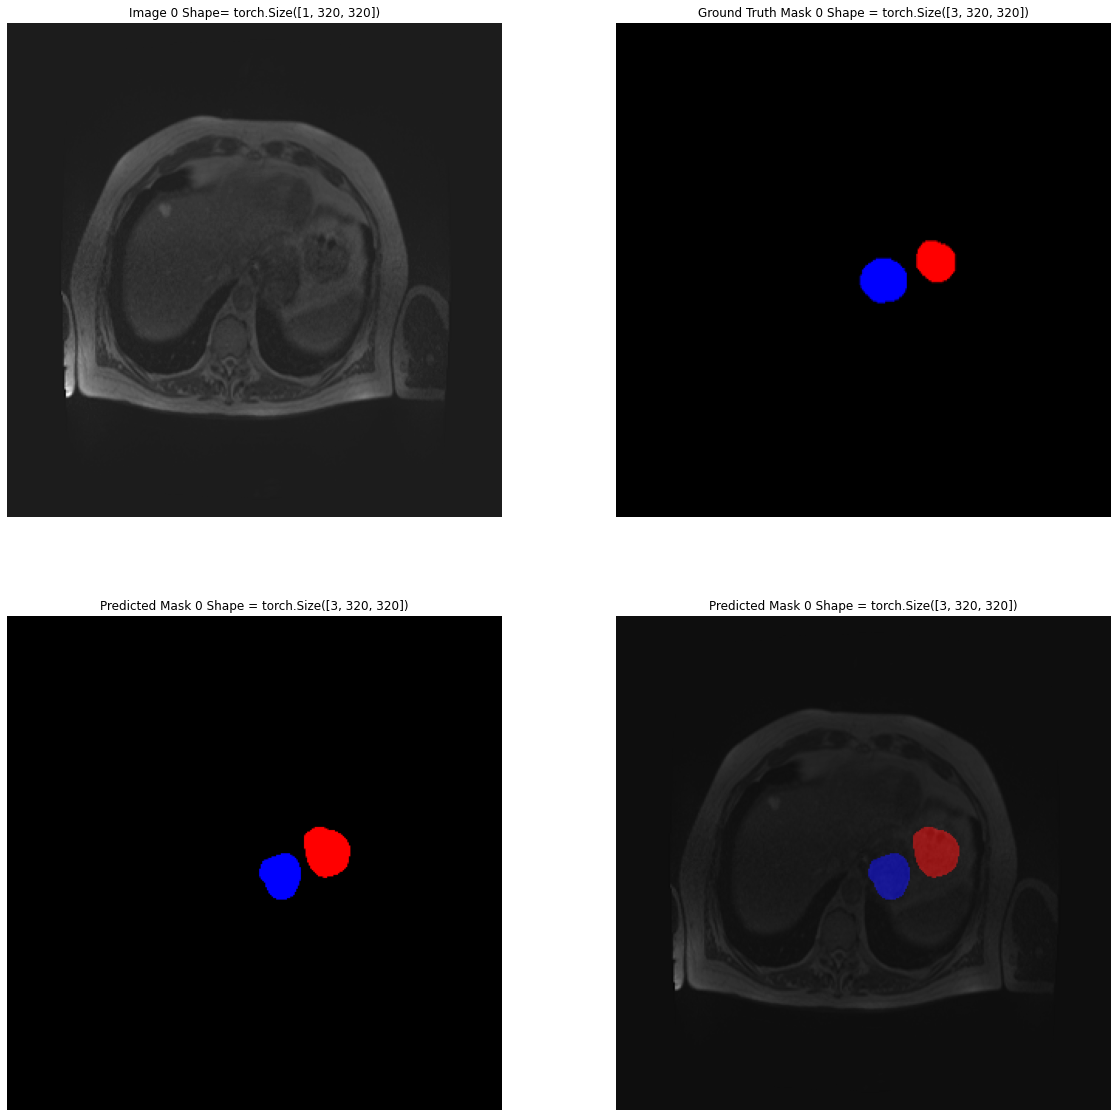

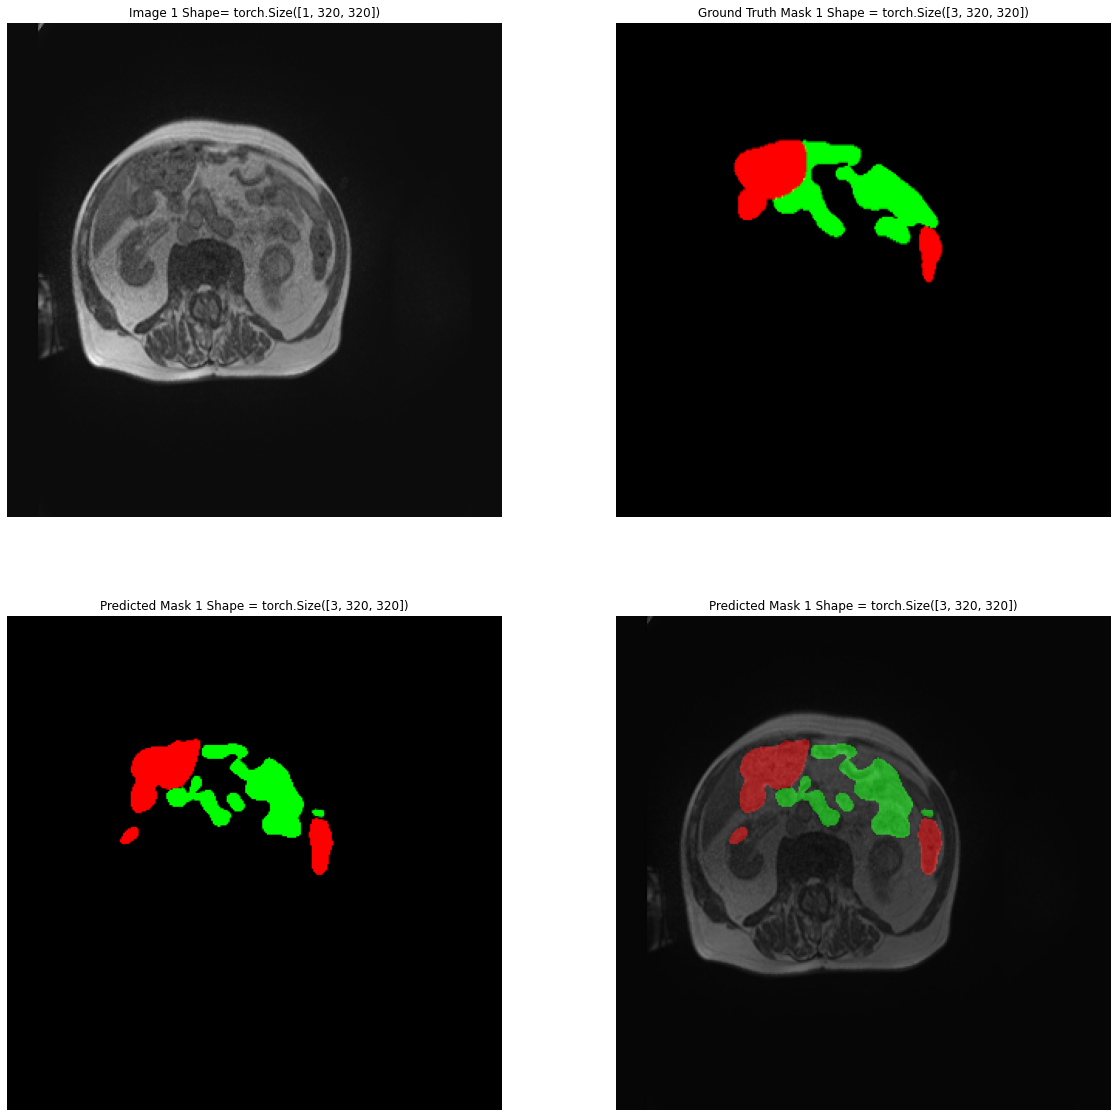

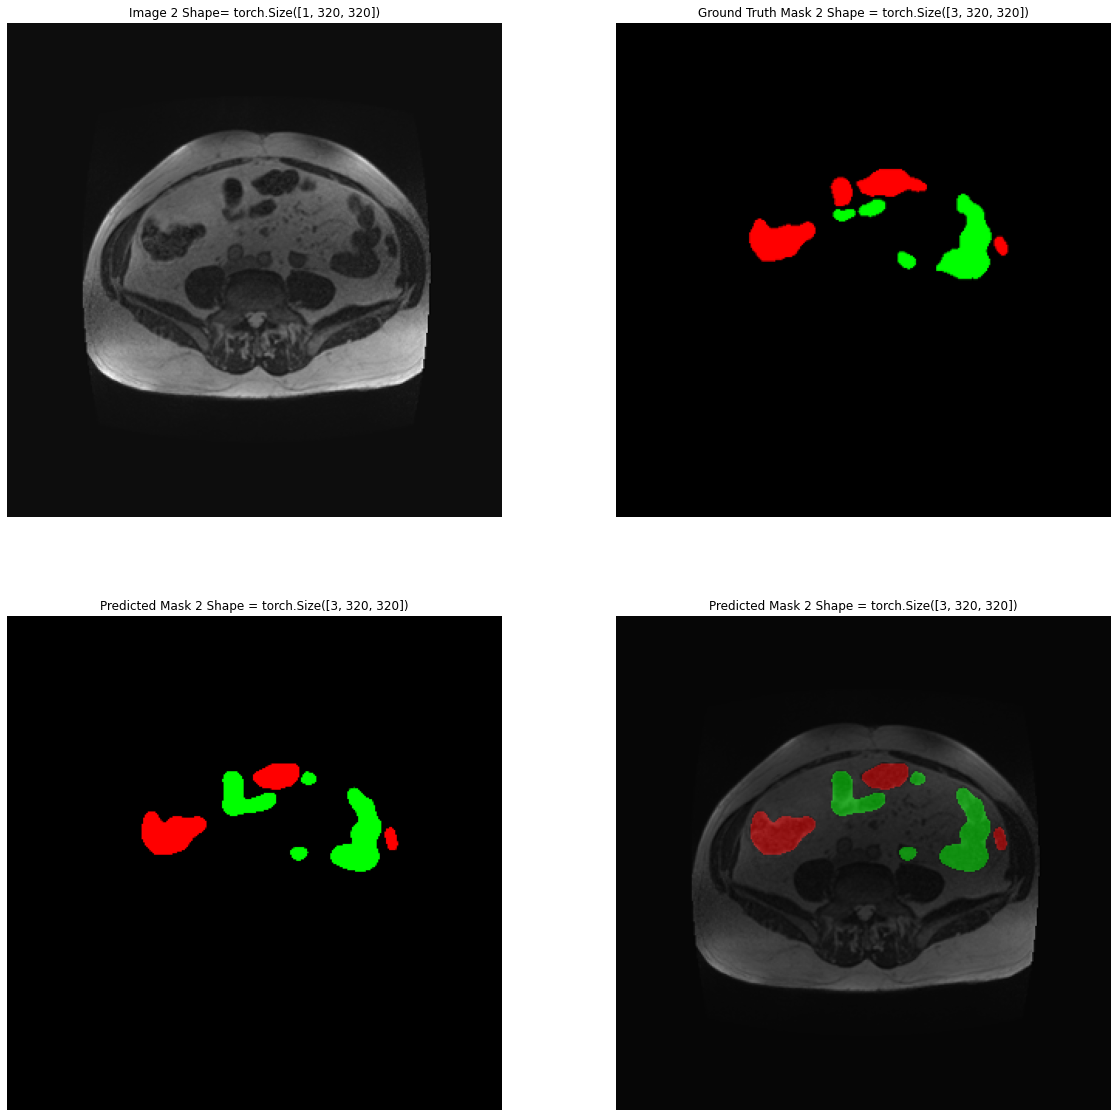

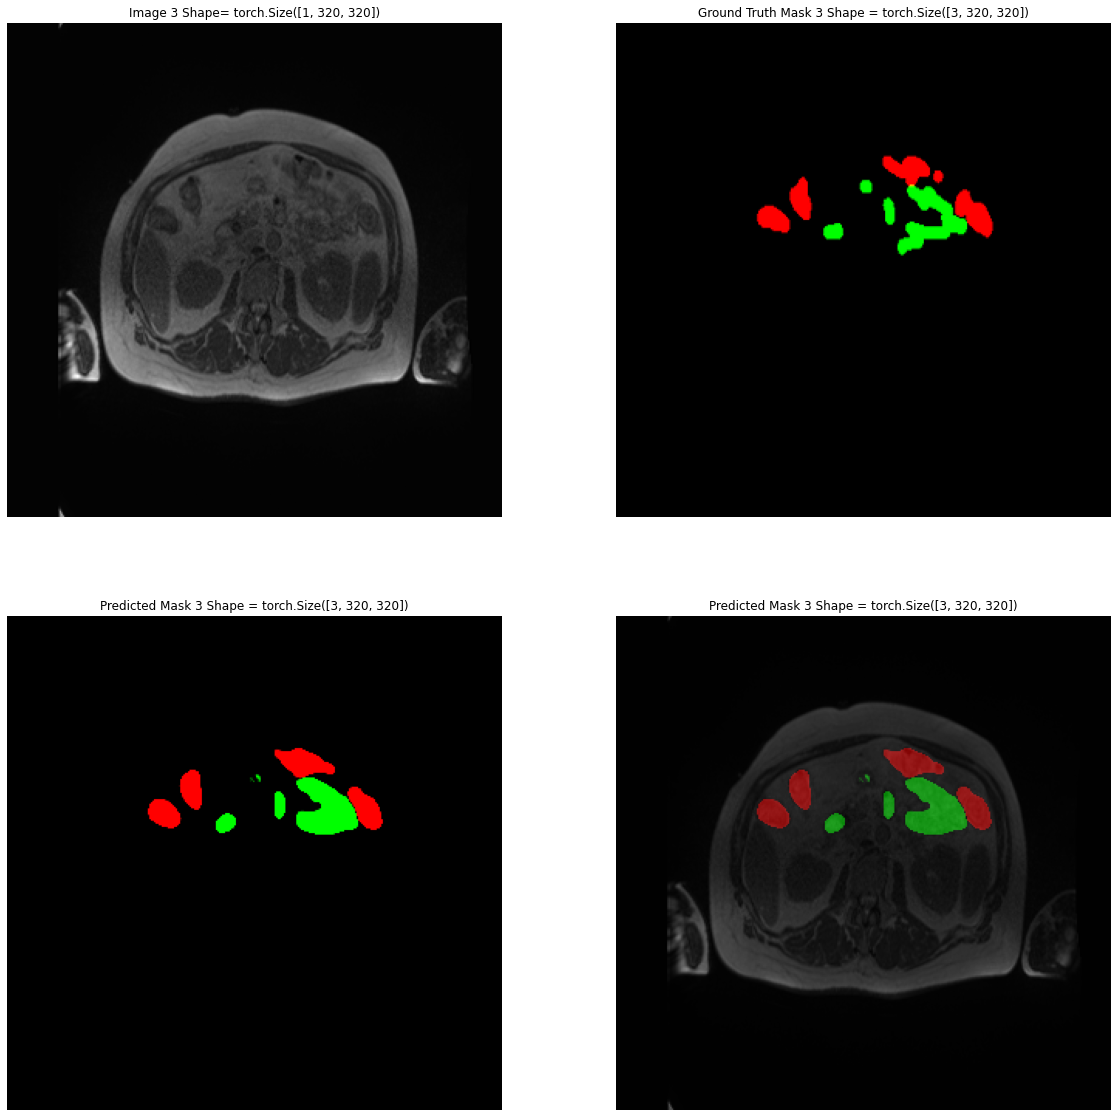

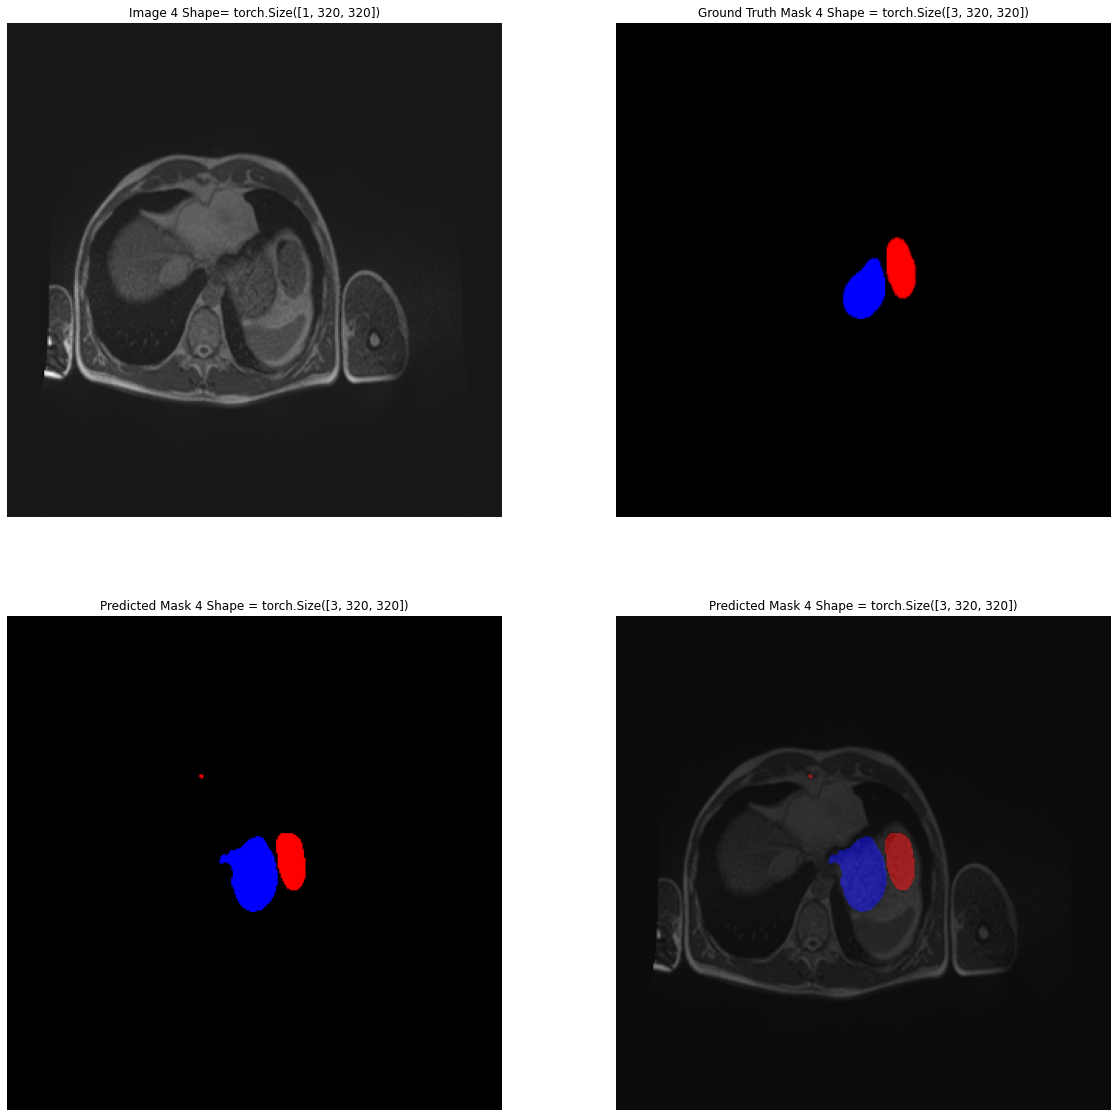

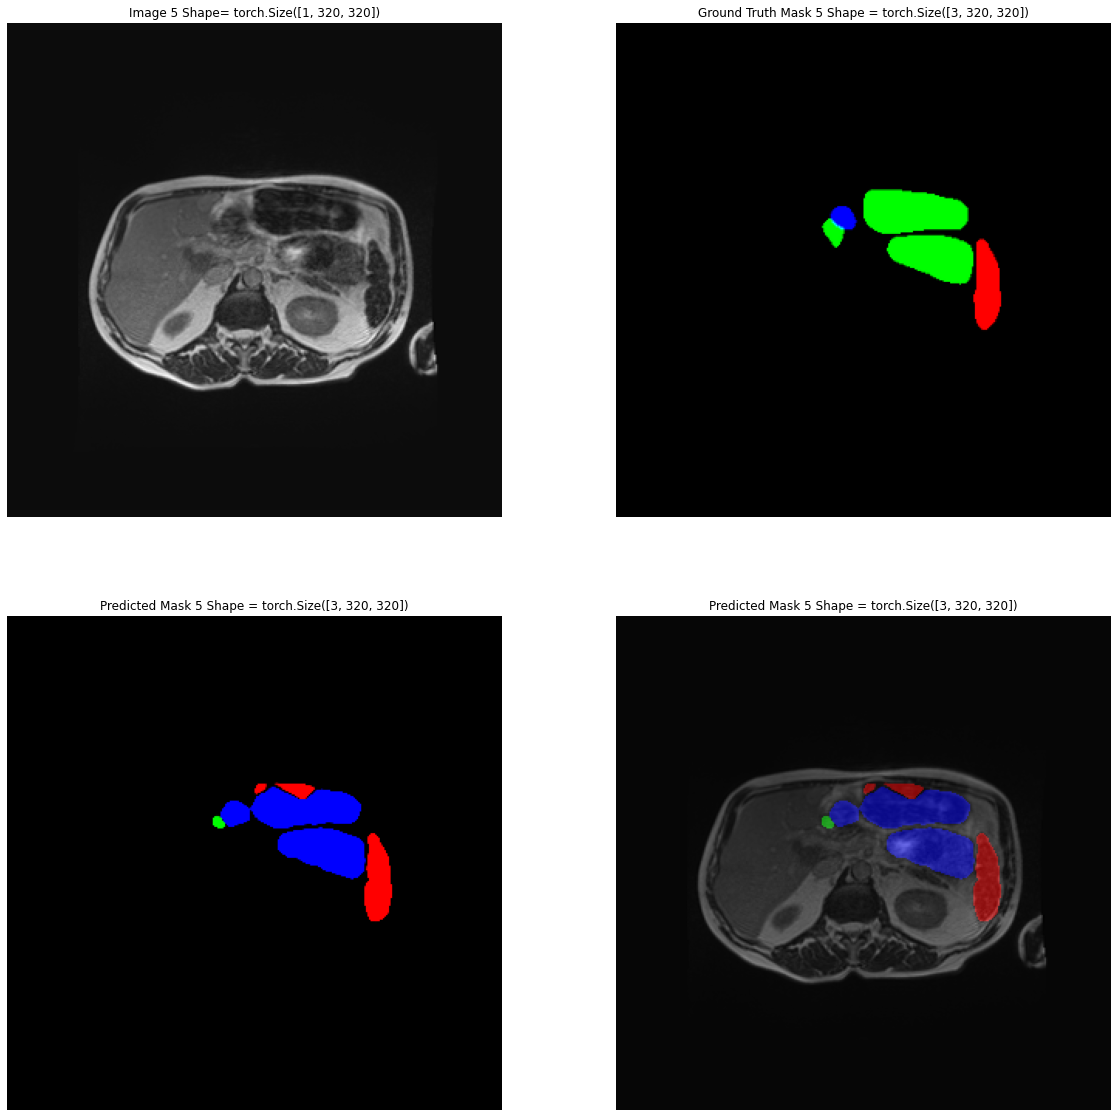

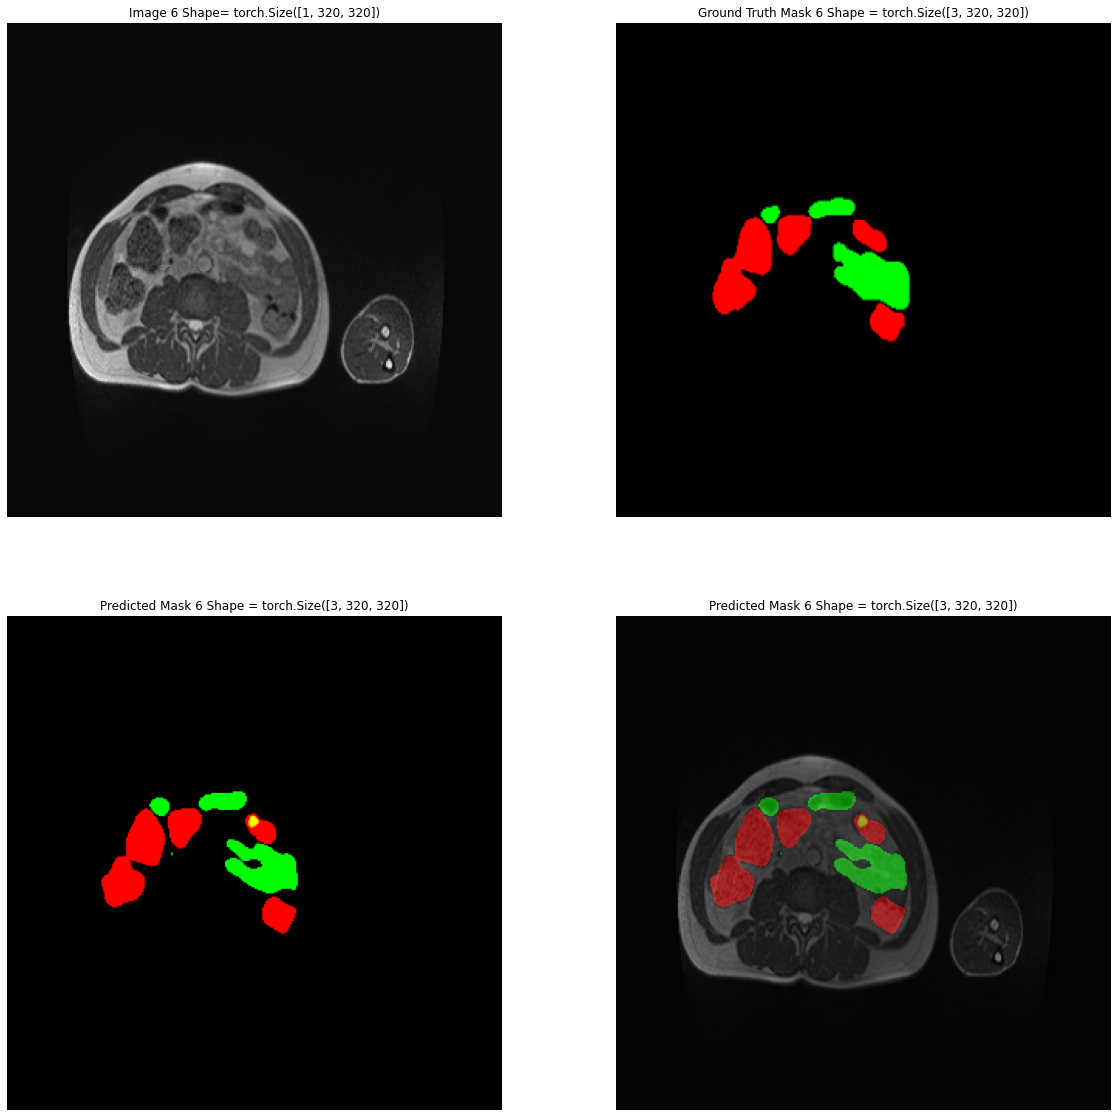

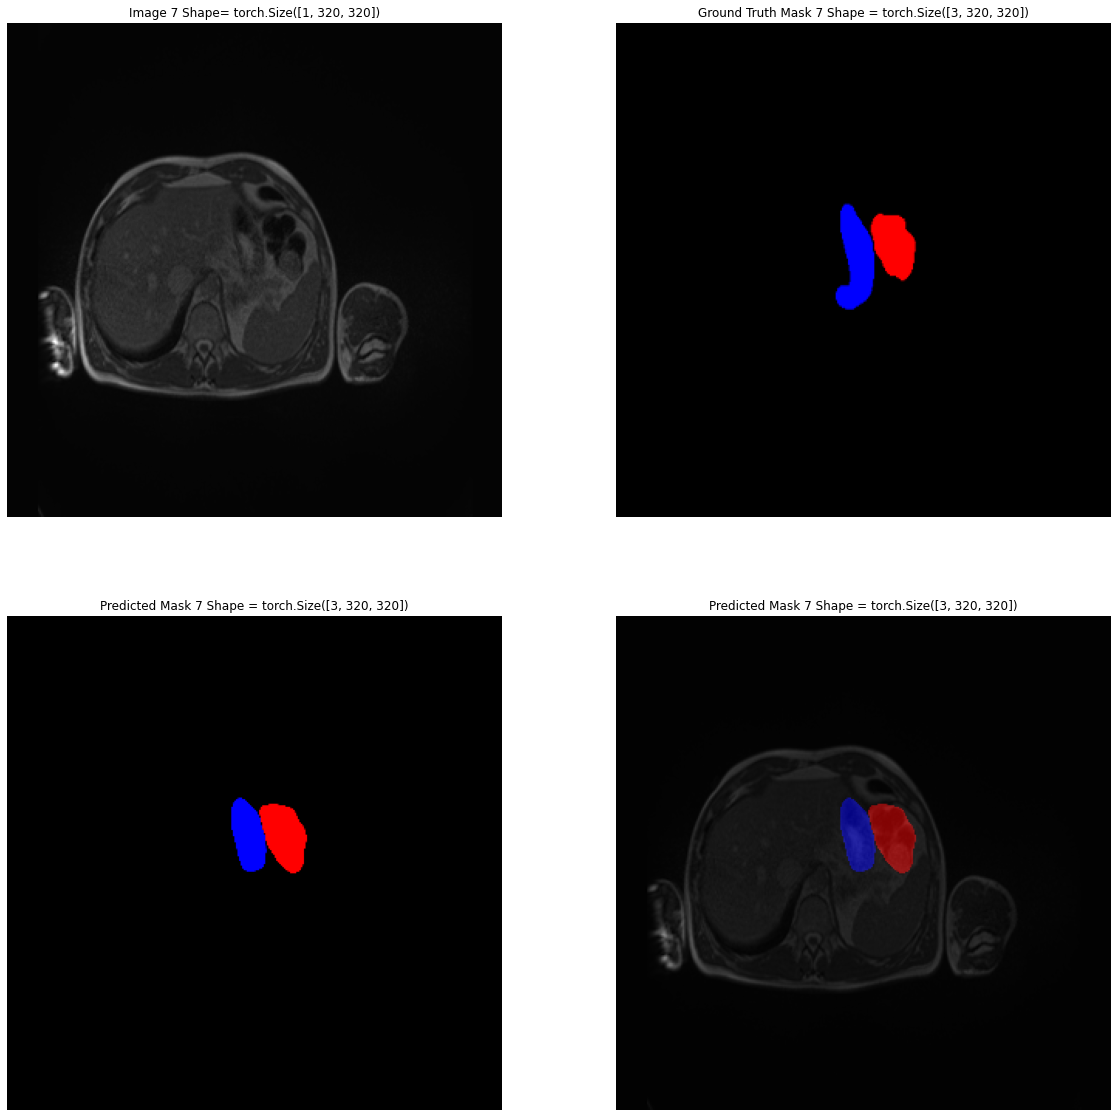

In [31]:
for idx in range(0,8):
    plot_result(data=data, output=output, idx=idx)

## Calculate the error metrics on the validation folds

In [24]:
model_name = "Unet-2-2.pth"
loss_fn = criterion
metric_fn = dice_coef
n_folds = int(df2d['fold'].max()) + 1

In [25]:

mean_metric = 0

for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    
    model_in_str = MODEL_FOLDER/("fold-" + str(fold) + '-' + model_name) 
    print(model_in_str)
    model.load_state_dict(torch.load(model_in_str))
    model.to(torch.device(DEVICE))
    model.eval()

    train_dataset, valid_dataset = prepare_datasets(df2d, fold, train_transforms, valid_transforms)
    

    valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                   batch_size=8,
                                                   num_workers=10,
                                                   pin_memory=True,
                                                   shuffle=True)
    
    

        
    validation_loss, validation_metric = validatefp32(valid_dataloader,
                                                      loss_fn,
                                                      metric_fn,
                                                      model)



    print('Fold-{}- Loss: {:.4f}, Metric = {:.3f}'.format(fold, validation_loss, validation_metric))
    
    mean_metric = mean_metric + validation_metric
    
print("Mean metric =",mean_metric/n_folds)    

/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-2-2.pth


  0%|          | 0/501 [00:00<?, ?it/s]

Fold-0- Loss: 0.1226, Metric = 0.796
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-2-2.pth


  0%|          | 0/494 [00:00<?, ?it/s]

Fold-1- Loss: 0.1177, Metric = 0.807
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-2-2.pth


  0%|          | 0/349 [00:00<?, ?it/s]

Fold-2- Loss: 0.1435, Metric = 0.751
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-2-2.pth


  0%|          | 0/367 [00:00<?, ?it/s]

Fold-3- Loss: 0.0853, Metric = 0.839
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-2-2.pth


  0%|          | 0/365 [00:00<?, ?it/s]

Fold-4- Loss: 0.1199, Metric = 0.791
Mean metric = tensor(0.7969, device='cuda:0')


In [ ]:
torch.cuda.empty_cache()